In [171]:
import numpy as np
from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler

from qiskit import Aer, execute
from qiskit.circuit import QuantumCircuit, Parameter, ParameterVector
from qiskit.circuit.library import PauliFeatureMap, ZFeatureMap, ZZFeatureMap
from qiskit.circuit.library import TwoLocal, NLocal, RealAmplitudes, EfficientSU2
from qiskit.circuit.library import HGate, RXGate, RYGate, RZGate, CXGate, CRXGate, CRZGate
from qiskit.circuit import Parameter, ParameterVector
from qiskit.opflow import I, X, Y, Z, StateFn

import numpy as np
import matplotlib.pyplot as plt

In [172]:
random_seed = 123

In [173]:
def load_iris_data():
    x, y = datasets.load_iris(return_X_y=True)

    # Reduce problem to binary classification
    is_class_2 = (y == 2) 
    x = x[~is_class_2]
    y = y[~is_class_2]
    y = y * 2 - 1  # map form {0, 1} to Z expectation values of {-1,+1}

    x_train, x_test, y_train, y_test = train_test_split(
        x, y, test_size=0.2, shuffle=True, random_state=random_seed
    )

    # Standardize data (i.e. mean of 0 with unit variance)
    std_scale = StandardScaler().fit(x_train)
    x_train = std_scale.transform(x_train)
    x_test = std_scale.transform(x_test)

    # Scale to between -1 and 1
    X_std = np.append(x_train, x_test, axis=0)
    minmax_scale = MinMaxScaler((-1, 1)).fit(X_std)
    x_train = minmax_scale.transform(x_train)
    x_test = minmax_scale.transform(x_test)
    return x_train, x_test, y_train, y_test

In [174]:
x_train, x_test, y_train, y_test = load_iris_data()

print(f'Training data shape: {x_train.shape}')
print(f'Testing data shape: {x_test.shape}')

Training data shape: (80, 4)
Testing data shape: (20, 4)


In [192]:
def initialize(x, N_dims):
    qc = QuantumCircuit(N_dims)
    mapper = lambda n: n[0] * np.pi
    qc.append(ZZFeatureMap(N_dims, reps=1, entanglement="circular", data_map_func=mapper), range(N_dims))
    return qc

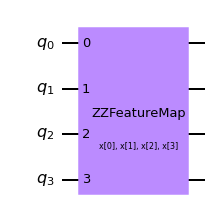

In [193]:
N = 4
qc = initialize(x_train[0], N)

qc.draw('mpl')

In [194]:
# We will implement the efficientSU2 ansatz
def efficientSU2(N_dims, gates=['rx', 'rz'], reps=1, entanglement='circular'):
    
    # Function to apply rotation gates to all of our qubits
    def rotation(gate, start):
        qc = QuantumCircuit(N_dims, name=gate)
        for i in range(N_dims):
            if gate == 'rx':
                qc.rx(parameters[start+i], i)
            if gate == 'ry':
                qc.ry(parameters[start+i], i)
            if gate == 'rz':
                qc.rz(parameters[start+i], i)
        return qc
    
    # Function apply the entanglement
    def entanglement(type=entanglement):
        qc = QuantumCircuit(N_dims, name=type)
        if (type == "circular"):
            qc.cx(N_dims-1, 0)
            for i in range(N_dims-1):
                target = i + 1
                qc.cx(i, target)
        if (type == "linear"):
            for i in range(N_dims - 1):
                target = i + 1
                qc.cx(i, target)
        if (type == "full"):
            for i in range(N_dims):
                for j in range(N_dims):
                    if (i != j):
                        qc.cx(i, j)
        return qc
    
    # Calculate the number of parameters we will need
    num_params = 2*len(gates)*N_dims*reps
    parameters = ParameterVector('θ', num_params)
    qc = QuantumCircuit(N_dims, name="EfficientSU2")
    start = 0
    
    for i in range(reps):
        for gate in gates:
            qc.append(rotation(gate, start), range(N_dims))
            start += N_dims

        qc.append(entanglement(), range(N_dims))
        
        for gate in gates:
            qc.append(rotation(gate, start), range(N_dims))
            start += N_dims
    
    return qc

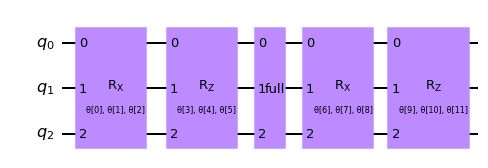

In [195]:
qc = efficientSU2(3, reps=1, entanglement='full')
qc.draw('mpl')

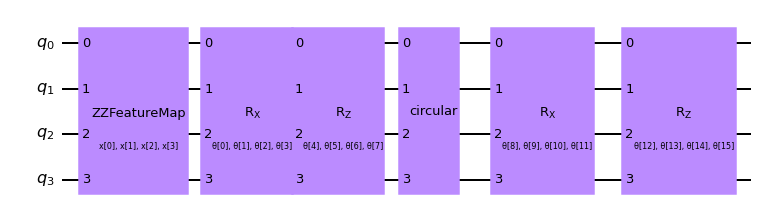

TypeError: __init__() takes from 2 to 3 positional arguments but 5 were given

In [196]:
def evaluate_expectation(theta, ansatz, expectation):
    value_dict = dict(zip(ansatz.parameters, theta))  # dictionary with parameter values
    expectation_bound = expectation.assign_parameters(value_dict)
    result = expectation_bound.eval()  
    return np.real(result)


N = 4
H = Z
qc = (initialize(x_train[0], N) + efficientSU2(N))
display(qc.draw('mpl'))
expectation = StateFn(H, is_measurement=True) @ StateFn(qc)

result = evaluate_expectation([np.random.random() for p in qc.parameters], qc, expectation)

print(result)


In [ ]:
eps = 0.002
e_i = np.array([0, 1])  # only vary one component of theta at a time

theta = np.random.rand(2)

plus = theta + eps * e_i
minus = theta - eps * e_i

grad = (evaluate_expectation(plus) - evaluate_expectation(minus)) / (2 * eps)

print(grad)